In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
import string
import re
from collections import Counter
import matplotlib.pyplot as plt

import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import LSTM, Input, Lambda, Dense
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.preprocessing import sequence

tqdm_notebook().pandas()

Using TensorFlow backend.


In [2]:
# data = pd.read_csv('train.csv').sample(10000, random_state=42)
data = pd.read_csv('train.csv', index_col='id')
data.reset_index(drop=True, inplace=True)

In [3]:
data.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
%%time
stops = set(stopwords.words('english')) - set(['not'])
snow = SnowballStemmer('english')
vocab = Counter()
max_sent_len = 0


def preprocessing(text):
    global vocab, max_sent_len
    text = str(text).lower()
    text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)

    text = [snow.stem(token) for token in word_tokenize(text) \
                 if token not in stops and token not in string.punctuation and len(token) > 2]
    
    if len(text) != 0:
        if len(text) > max_sent_len:
                max_sent_len = len(text)
        for word in text:
            vocab[word] += 1
    
    return text

data['question1'] = data['question1'].progress_apply(preprocessing)
data['question2'] = data['question2'].progress_apply(preprocessing)

questions = pd.concat([data['question1'], data['question2']])
questions.dropna(inplace=True)
print(questions.shape)


(808580,)
Wall time: 3min 59s


In [5]:
data.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",0
1,3,4,"[stori, kohinoor, koh-i-noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",0
2,5,6,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dns]",0
3,7,8,"[mental, lone, solv]","[find, remaind, math, 23^, /math, divid, 24,23]",0
4,9,10,"[one, dissolv, water, quik, sugar, salt, metha...","[fish, would, surviv, salt, water]",0


In [6]:
%%time
embed_dim = 300
w2v_model = Word2Vec(questions.values, min_count=1, size=embed_dim, workers=4)
w2v_vocab = w2v_model.wv.vocab

Wall time: 35.3 s


In [7]:
vocab.most_common(10)

[('best', 70491),
 ('get', 44019),
 ('not', 43235),
 ('india', 29419),
 ('like', 28268),
 ('use', 27043),
 ('peopl', 26497),
 ('good', 25071),
 ('way', 24971),
 ('differ', 24091)]

In [8]:
%%time
word_idx = dict()
index = 1
num_words = 10000

# 'word_idx' contains the word-index relationship of the top 'num_words' frequent occuring Tokens
for key, value in vocab.most_common(num_words):
    if not word_idx.get(key):
        word_idx[key] = index
        index += 1

# This Function will take every Tokenized question and return a sequence of Word Vectors for each sentence
# def text_to_vect(text):
#     '''
#     for word in text:
#         if word_idx.get(word):
#             vectorized.append(w2v_model.wv[word])
#     '''
#     vectorized = [w2v_model.wv[word] for word in text if word_idx.get(word)]
#     return vectorized

def text_to_index(text):
    return [word_idx.get(word) for word in text if word_idx.get(word)]
        
# q1_vectors = data['question1'].progress_apply(text_to_vect)
# q2_vectors = data['question2'].progress_apply(text_to_vect)

data['q1_idx'] = data['question1'].progress_apply(text_to_index)
data['q2_idx'] = data['question2'].progress_apply(text_to_index)


Wall time: 3.85 s


In [9]:
data.head()

,qid1,qid2,question1,question2,is_duplicate,q1_idx,q2_idx
0,1,2,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",0,"[572, 572, 1751, 171, 414, 107, 4]","[572, 572, 1751, 171, 414, 107]"
1,3,4,"[stori, kohinoor, koh-i-noor, diamond]","[would, happen, indian, govern, stole, kohinoo...",0,"[278, 9995, 2789]","[11, 41, 26, 153, 7800, 9995, 2789, 141]"
2,5,6,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dns]",0,"[130, 364, 294, 452, 6, 2286]","[294, 364, 130, 169, 7673]"
3,7,8,"[mental, lone, solv]","[find, remaind, math, 23^, /math, divid, 24,23]",0,"[969, 2124, 429]","[35, 3126, 227, 584, 1535]"
4,9,10,"[one, dissolv, water, quik, sugar, salt, metha...","[fish, would, surviv, salt, water]",0,"[13, 4238, 165, 1647, 1640, 7322, 1376, 2681]","[1422, 11, 867, 1640, 165]"


In [10]:
%%time
import pickle

data.to_csv('Indexed_Data.csv')
pickle.dump(vocab, open("Vocab.pkl", "wb"))
pickle.dump(word_idx, open("Word_Idx.pkl", "wb"))
pickle.dump(w2v_model, open("Word2Vec_Model.pkl", "wb"))

Wall time: 7.52 s


In [11]:
print(len(vocab))
print(max_sent_len)
print(len(word_idx))

89384
101
10000


In [12]:
max(max(data['question1'].apply(len)), max(data['question2'].apply(len)))

101

In [13]:
%%time
# split = int(0.7 * data.shape[0])
split = 50000
data_train = data.iloc[:split]
data_test = data.iloc[split: split+10000]

del data

x_train = {}; x_test = {};
x_train['left'] = data_train['q1_idx'].values
x_train['right'] = data_train['q2_idx'].values

x_test['left'] = data_test['q1_idx'].values
x_test['right'] = data_test['q2_idx'].values

y_train = data_train['is_duplicate'].values
y_test = data_test['is_duplicate'].values

print(f"X_Train shape -> left={x_train['left'].shape} & right={x_train['right'].shape}")
print(f"X_Test shape -> left={x_test['left'].shape} & right={x_test['right'].shape}")
print(f"Y_Train shape -> {y_train.shape}")
print(f"Y_Test shape -> {y_test.shape}")

X_Train shape -> left=(50000,) & right=(50000,)
X_Test shape -> left=(10000,) & right=(10000,)
Y_Train shape -> (50000,)
Y_Test shape -> (10000,)
Wall time: 17 ms


In [14]:
%%time
embeddings = 1 * np.random.randn(num_words + 237, 300)
embeddings[0] = 0

# Build the embedding matrix
for word, index in word_idx.items():
    if w2v_vocab.get(word):
        embeddings[index] = w2v_model.wv[word]

print(embeddings.shape)

(10237, 300)
Wall time: 155 ms


In [15]:
%%time
max_length = 100
x_train['left'] = sequence.pad_sequences(x_train['left'], maxlen=max_length)
x_train['right'] = sequence.pad_sequences(x_train['right'], maxlen=max_length)
x_test['left'] = sequence.pad_sequences(x_test['left'], maxlen=max_length)
x_test['right'] = sequence.pad_sequences(x_test['right'], maxlen=max_length)

Wall time: 747 ms


In [16]:
x_train['left'][0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  572,  572, 1751,  171,  414,  107,
          4])

In [17]:
%%time
# Model variables
n_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 15

def exp_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

input_left = Input(shape=(max_length, ), dtype='int32', name='left_input')
input_right = Input(shape=(max_length, ), dtype='int32', name='right_input')

embed_left = Embedding(output_dim=300, input_dim=num_words+237, input_length=max_length, \
                         weights=[embeddings], name='left_embedding', trainable=False)(input_left)
embed_right = Embedding(output_dim=300, input_dim=num_words+237, input_length=max_length, \
                          weights=[embeddings], name='right_embedding', trainable=False)(input_right)

shared_lstm = LSTM(n_hidden, dropout=0.5, recurrent_dropout=0.5)

output_left = shared_lstm(embed_left)
output_right = shared_lstm(embed_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exp_neg_manhattan_distance(x[0], x[1]), \
                         output_shape=lambda x: (x[0][0], 1))([output_left, output_right])

malstm = Model(inputs=[input_left, input_right], outputs=[malstm_distance])

optimizer = Adam(clipnorm=gradient_clipping_norm, lr=0.001)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

malstm_trained = malstm.fit([x_train['left'], x_train['right']], y_train, batch_size=batch_size, nb_epoch=n_epoch, \
                            validation_data=([x_test['left'], x_test['right']], y_test), verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15


12992/50000 [======>.......................] - ETA: 29:22 - loss: 0.3594 - acc: 0.64 - ETA: 19:00 - loss: 0.3359 - acc: 0.66 - ETA: 15:31 - loss: 0.3490 - acc: 0.65 - ETA: 13:46 - loss: 0.3555 - acc: 0.64 - ETA: 12:43 - loss: 0.3469 - acc: 0.65 - ETA: 12:15 - loss: 0.3568 - acc: 0.64 - ETA: 11:38 - loss: 0.3594 - acc: 0.64 - ETA: 11:13 - loss: 0.3477 - acc: 0.65 - ETA: 10:51 - loss: 0.3524 - acc: 0.64 - ETA: 10:34 - loss: 0.3484 - acc: 0.65 - ETA: 10:20 - loss: 0.3580 - acc: 0.64 - ETA: 10:06 - loss: 0.3633 - acc: 0.63 - ETA: 9:56 - loss: 0.3630 - acc: 0.6370 - ETA: 9:48 - loss: 0.3637 - acc: 0.636 - ETA: 9:40 - loss: 0.3676 - acc: 0.632 - ETA: 9:34 - loss: 0.3681 - acc: 0.631 - ETA: 9:28 - loss: 0.3703 - acc: 0.629 - ETA: 9:22 - loss: 0.3671 - acc: 0.632 - ETA: 9:17 - loss: 0.3659 - acc: 0.634 - ETA: 9:13 - loss: 0.3640 - acc: 0.635 - ETA: 9:09 - loss: 0.3645 - acc: 0.635 - ETA: 9:06 - loss: 0.3657 - acc: 0.634 - ETA: 9:03 - loss: 0.3681 - acc: 0.631 - ETA: 8:58 - loss: 0.3680 - acc: 

39104/50000 [======================>.......] - ETA: 4:07 - loss: 0.3413 - acc: 0.634 - ETA: 4:06 - loss: 0.3412 - acc: 0.634 - ETA: 4:06 - loss: 0.3410 - acc: 0.634 - ETA: 4:05 - loss: 0.3406 - acc: 0.634 - ETA: 4:05 - loss: 0.3403 - acc: 0.634 - ETA: 4:04 - loss: 0.3400 - acc: 0.635 - ETA: 4:03 - loss: 0.3398 - acc: 0.635 - ETA: 4:03 - loss: 0.3396 - acc: 0.634 - ETA: 4:02 - loss: 0.3394 - acc: 0.634 - ETA: 4:01 - loss: 0.3391 - acc: 0.634 - ETA: 4:01 - loss: 0.3388 - acc: 0.635 - ETA: 4:00 - loss: 0.3385 - acc: 0.634 - ETA: 3:59 - loss: 0.3382 - acc: 0.634 - ETA: 3:59 - loss: 0.3383 - acc: 0.634 - ETA: 3:58 - loss: 0.3381 - acc: 0.634 - ETA: 3:57 - loss: 0.3379 - acc: 0.634 - ETA: 3:57 - loss: 0.3377 - acc: 0.634 - ETA: 3:56 - loss: 0.3375 - acc: 0.634 - ETA: 3:55 - loss: 0.3372 - acc: 0.634 - ETA: 3:55 - loss: 0.3369 - acc: 0.634 - ETA: 3:54 - loss: 0.3367 - acc: 0.634 - ETA: 3:53 - loss: 0.3363 - acc: 0.635 - ETA: 3:53 - loss: 0.3361 - acc: 0.635 - ETA: 3:52 - loss: 0.3358 - acc: 0

50000/50000 [==============================] - ETA: 1:53 - loss: 0.3004 - acc: 0.647 - ETA: 1:52 - loss: 0.3003 - acc: 0.647 - ETA: 1:52 - loss: 0.3001 - acc: 0.647 - ETA: 1:51 - loss: 0.3000 - acc: 0.647 - ETA: 1:50 - loss: 0.3000 - acc: 0.647 - ETA: 1:50 - loss: 0.2998 - acc: 0.647 - ETA: 1:49 - loss: 0.2997 - acc: 0.647 - ETA: 1:48 - loss: 0.2995 - acc: 0.647 - ETA: 1:48 - loss: 0.2993 - acc: 0.647 - ETA: 1:47 - loss: 0.2991 - acc: 0.647 - ETA: 1:46 - loss: 0.2990 - acc: 0.648 - ETA: 1:46 - loss: 0.2989 - acc: 0.648 - ETA: 1:45 - loss: 0.2987 - acc: 0.648 - ETA: 1:44 - loss: 0.2985 - acc: 0.648 - ETA: 1:44 - loss: 0.2984 - acc: 0.648 - ETA: 1:43 - loss: 0.2982 - acc: 0.648 - ETA: 1:42 - loss: 0.2980 - acc: 0.648 - ETA: 1:42 - loss: 0.2979 - acc: 0.648 - ETA: 1:41 - loss: 0.2978 - acc: 0.648 - ETA: 1:40 - loss: 0.2977 - acc: 0.648 - ETA: 1:40 - loss: 0.2976 - acc: 0.648 - ETA: 1:39 - loss: 0.2974 - acc: 0.648 - ETA: 1:38 - loss: 0.2973 - acc: 0.648 - ETA: 1:38 - loss: 0.2972 - acc: 0

13056/50000 [======>.......................] - ETA: 10:59 - loss: 0.1827 - acc: 0.75 - ETA: 10:50 - loss: 0.1885 - acc: 0.71 - ETA: 10:42 - loss: 0.1780 - acc: 0.73 - ETA: 10:28 - loss: 0.1786 - acc: 0.73 - ETA: 10:08 - loss: 0.1855 - acc: 0.73 - ETA: 9:52 - loss: 0.1968 - acc: 0.7109 - ETA: 9:39 - loss: 0.1966 - acc: 0.707 - ETA: 9:29 - loss: 0.1995 - acc: 0.697 - ETA: 9:20 - loss: 0.2035 - acc: 0.685 - ETA: 9:12 - loss: 0.2037 - acc: 0.685 - ETA: 9:05 - loss: 0.2023 - acc: 0.690 - ETA: 9:00 - loss: 0.2013 - acc: 0.691 - ETA: 8:56 - loss: 0.2008 - acc: 0.694 - ETA: 8:52 - loss: 0.1998 - acc: 0.696 - ETA: 8:49 - loss: 0.1977 - acc: 0.701 - ETA: 8:44 - loss: 0.1976 - acc: 0.705 - ETA: 8:44 - loss: 0.2003 - acc: 0.698 - ETA: 8:42 - loss: 0.1995 - acc: 0.698 - ETA: 8:42 - loss: 0.1968 - acc: 0.702 - ETA: 8:39 - loss: 0.1981 - acc: 0.700 - ETA: 8:37 - loss: 0.1991 - acc: 0.697 - ETA: 8:35 - loss: 0.2001 - acc: 0.693 - ETA: 8:34 - loss: 0.2008 - acc: 0.694 - ETA: 8:33 - loss: 0.2004 - acc: 

39168/50000 [======================>.......] - ETA: 4:02 - loss: 0.2019 - acc: 0.689 - ETA: 4:02 - loss: 0.2019 - acc: 0.689 - ETA: 4:01 - loss: 0.2019 - acc: 0.689 - ETA: 4:00 - loss: 0.2019 - acc: 0.689 - ETA: 4:00 - loss: 0.2018 - acc: 0.689 - ETA: 3:59 - loss: 0.2018 - acc: 0.689 - ETA: 3:58 - loss: 0.2018 - acc: 0.689 - ETA: 3:58 - loss: 0.2018 - acc: 0.689 - ETA: 3:57 - loss: 0.2018 - acc: 0.689 - ETA: 3:56 - loss: 0.2018 - acc: 0.689 - ETA: 3:56 - loss: 0.2017 - acc: 0.689 - ETA: 3:55 - loss: 0.2017 - acc: 0.689 - ETA: 3:54 - loss: 0.2018 - acc: 0.689 - ETA: 3:54 - loss: 0.2018 - acc: 0.689 - ETA: 3:53 - loss: 0.2019 - acc: 0.689 - ETA: 3:52 - loss: 0.2019 - acc: 0.689 - ETA: 3:52 - loss: 0.2019 - acc: 0.689 - ETA: 3:51 - loss: 0.2019 - acc: 0.689 - ETA: 3:50 - loss: 0.2019 - acc: 0.689 - ETA: 3:49 - loss: 0.2018 - acc: 0.689 - ETA: 3:49 - loss: 0.2018 - acc: 0.689 - ETA: 3:48 - loss: 0.2018 - acc: 0.689 - ETA: 3:47 - loss: 0.2018 - acc: 0.689 - ETA: 3:47 - loss: 0.2017 - acc: 0

50000/50000 [==============================] - ETA: 1:48 - loss: 0.2011 - acc: 0.691 - ETA: 1:47 - loss: 0.2010 - acc: 0.691 - ETA: 1:46 - loss: 0.2010 - acc: 0.691 - ETA: 1:46 - loss: 0.2010 - acc: 0.691 - ETA: 1:45 - loss: 0.2010 - acc: 0.691 - ETA: 1:44 - loss: 0.2010 - acc: 0.691 - ETA: 1:44 - loss: 0.2009 - acc: 0.691 - ETA: 1:43 - loss: 0.2009 - acc: 0.691 - ETA: 1:43 - loss: 0.2009 - acc: 0.691 - ETA: 1:42 - loss: 0.2010 - acc: 0.691 - ETA: 1:41 - loss: 0.2010 - acc: 0.691 - ETA: 1:41 - loss: 0.2010 - acc: 0.691 - ETA: 1:40 - loss: 0.2010 - acc: 0.691 - ETA: 1:39 - loss: 0.2010 - acc: 0.691 - ETA: 1:39 - loss: 0.2010 - acc: 0.691 - ETA: 1:38 - loss: 0.2010 - acc: 0.691 - ETA: 1:37 - loss: 0.2010 - acc: 0.691 - ETA: 1:37 - loss: 0.2010 - acc: 0.691 - ETA: 1:36 - loss: 0.2010 - acc: 0.691 - ETA: 1:35 - loss: 0.2009 - acc: 0.691 - ETA: 1:35 - loss: 0.2010 - acc: 0.691 - ETA: 1:34 - loss: 0.2009 - acc: 0.691 - ETA: 1:33 - loss: 0.2010 - acc: 0.691 - ETA: 1:33 - loss: 0.2010 - acc: 0

13056/50000 [======>.......................] - ETA: 8:24 - loss: 0.2238 - acc: 0.625 - ETA: 8:30 - loss: 0.2100 - acc: 0.664 - ETA: 8:20 - loss: 0.2017 - acc: 0.687 - ETA: 8:18 - loss: 0.1937 - acc: 0.703 - ETA: 8:22 - loss: 0.1942 - acc: 0.700 - ETA: 8:21 - loss: 0.1889 - acc: 0.716 - ETA: 8:21 - loss: 0.1889 - acc: 0.716 - ETA: 8:21 - loss: 0.1874 - acc: 0.718 - ETA: 8:19 - loss: 0.1893 - acc: 0.710 - ETA: 8:20 - loss: 0.1894 - acc: 0.710 - ETA: 8:21 - loss: 0.1837 - acc: 0.721 - ETA: 8:21 - loss: 0.1862 - acc: 0.713 - ETA: 8:21 - loss: 0.1881 - acc: 0.709 - ETA: 8:20 - loss: 0.1894 - acc: 0.706 - ETA: 8:20 - loss: 0.1906 - acc: 0.700 - ETA: 8:19 - loss: 0.1893 - acc: 0.701 - ETA: 8:18 - loss: 0.1887 - acc: 0.704 - ETA: 8:17 - loss: 0.1898 - acc: 0.702 - ETA: 8:17 - loss: 0.1911 - acc: 0.701 - ETA: 8:21 - loss: 0.1910 - acc: 0.703 - ETA: 8:20 - loss: 0.1912 - acc: 0.704 - ETA: 8:19 - loss: 0.1918 - acc: 0.703 - ETA: 8:21 - loss: 0.1919 - acc: 0.702 - ETA: 8:19 - loss: 0.1924 - acc: 0

39168/50000 [======================>.......] - ETA: 4:09 - loss: 0.1944 - acc: 0.703 - ETA: 4:08 - loss: 0.1945 - acc: 0.703 - ETA: 4:07 - loss: 0.1944 - acc: 0.703 - ETA: 4:07 - loss: 0.1944 - acc: 0.703 - ETA: 4:06 - loss: 0.1944 - acc: 0.704 - ETA: 4:05 - loss: 0.1943 - acc: 0.704 - ETA: 4:04 - loss: 0.1943 - acc: 0.704 - ETA: 4:04 - loss: 0.1942 - acc: 0.704 - ETA: 4:03 - loss: 0.1942 - acc: 0.704 - ETA: 4:02 - loss: 0.1943 - acc: 0.704 - ETA: 4:02 - loss: 0.1942 - acc: 0.704 - ETA: 4:01 - loss: 0.1942 - acc: 0.704 - ETA: 4:00 - loss: 0.1942 - acc: 0.704 - ETA: 4:00 - loss: 0.1943 - acc: 0.704 - ETA: 3:59 - loss: 0.1944 - acc: 0.704 - ETA: 3:58 - loss: 0.1945 - acc: 0.704 - ETA: 3:58 - loss: 0.1945 - acc: 0.704 - ETA: 3:57 - loss: 0.1944 - acc: 0.704 - ETA: 3:56 - loss: 0.1944 - acc: 0.703 - ETA: 3:55 - loss: 0.1944 - acc: 0.703 - ETA: 3:55 - loss: 0.1944 - acc: 0.703 - ETA: 3:54 - loss: 0.1943 - acc: 0.704 - ETA: 3:53 - loss: 0.1942 - acc: 0.704 - ETA: 3:53 - loss: 0.1941 - acc: 0

50000/50000 [==============================] - ETA: 1:50 - loss: 0.1943 - acc: 0.704 - ETA: 1:49 - loss: 0.1944 - acc: 0.704 - ETA: 1:49 - loss: 0.1944 - acc: 0.704 - ETA: 1:48 - loss: 0.1943 - acc: 0.704 - ETA: 1:47 - loss: 0.1943 - acc: 0.704 - ETA: 1:47 - loss: 0.1944 - acc: 0.704 - ETA: 1:46 - loss: 0.1944 - acc: 0.704 - ETA: 1:45 - loss: 0.1944 - acc: 0.704 - ETA: 1:44 - loss: 0.1944 - acc: 0.704 - ETA: 1:44 - loss: 0.1944 - acc: 0.704 - ETA: 1:43 - loss: 0.1944 - acc: 0.704 - ETA: 1:42 - loss: 0.1944 - acc: 0.704 - ETA: 1:42 - loss: 0.1944 - acc: 0.704 - ETA: 1:41 - loss: 0.1944 - acc: 0.704 - ETA: 1:40 - loss: 0.1944 - acc: 0.704 - ETA: 1:40 - loss: 0.1944 - acc: 0.704 - ETA: 1:39 - loss: 0.1944 - acc: 0.704 - ETA: 1:38 - loss: 0.1945 - acc: 0.704 - ETA: 1:38 - loss: 0.1945 - acc: 0.704 - ETA: 1:37 - loss: 0.1945 - acc: 0.704 - ETA: 1:36 - loss: 0.1946 - acc: 0.704 - ETA: 1:36 - loss: 0.1947 - acc: 0.704 - ETA: 1:35 - loss: 0.1947 - acc: 0.704 - ETA: 1:34 - loss: 0.1946 - acc: 0

13056/50000 [======>.......................] - ETA: 9:07 - loss: 0.2074 - acc: 0.687 - ETA: 8:36 - loss: 0.1900 - acc: 0.718 - ETA: 8:25 - loss: 0.1987 - acc: 0.687 - ETA: 8:26 - loss: 0.1898 - acc: 0.699 - ETA: 8:23 - loss: 0.1934 - acc: 0.693 - ETA: 8:23 - loss: 0.1909 - acc: 0.708 - ETA: 8:17 - loss: 0.1899 - acc: 0.707 - ETA: 8:17 - loss: 0.1964 - acc: 0.699 - ETA: 8:17 - loss: 0.1948 - acc: 0.697 - ETA: 8:15 - loss: 0.1910 - acc: 0.704 - ETA: 8:15 - loss: 0.1907 - acc: 0.707 - ETA: 8:14 - loss: 0.1916 - acc: 0.707 - ETA: 8:13 - loss: 0.1933 - acc: 0.704 - ETA: 8:12 - loss: 0.1917 - acc: 0.707 - ETA: 8:13 - loss: 0.1932 - acc: 0.703 - ETA: 8:12 - loss: 0.1944 - acc: 0.702 - ETA: 8:12 - loss: 0.1940 - acc: 0.702 - ETA: 8:11 - loss: 0.1949 - acc: 0.701 - ETA: 8:11 - loss: 0.1936 - acc: 0.702 - ETA: 8:11 - loss: 0.1916 - acc: 0.709 - ETA: 8:11 - loss: 0.1925 - acc: 0.710 - ETA: 8:10 - loss: 0.1927 - acc: 0.708 - ETA: 8:09 - loss: 0.1940 - acc: 0.705 - ETA: 8:08 - loss: 0.1932 - acc: 0

39168/50000 [======================>.......] - ETA: 3:58 - loss: 0.1913 - acc: 0.709 - ETA: 3:57 - loss: 0.1913 - acc: 0.708 - ETA: 3:56 - loss: 0.1914 - acc: 0.708 - ETA: 3:56 - loss: 0.1913 - acc: 0.708 - ETA: 3:55 - loss: 0.1913 - acc: 0.708 - ETA: 3:54 - loss: 0.1913 - acc: 0.708 - ETA: 3:54 - loss: 0.1913 - acc: 0.708 - ETA: 3:53 - loss: 0.1914 - acc: 0.708 - ETA: 3:52 - loss: 0.1914 - acc: 0.708 - ETA: 3:52 - loss: 0.1913 - acc: 0.708 - ETA: 3:51 - loss: 0.1913 - acc: 0.708 - ETA: 3:51 - loss: 0.1913 - acc: 0.708 - ETA: 3:50 - loss: 0.1913 - acc: 0.708 - ETA: 3:49 - loss: 0.1914 - acc: 0.708 - ETA: 3:49 - loss: 0.1914 - acc: 0.708 - ETA: 3:48 - loss: 0.1914 - acc: 0.708 - ETA: 3:47 - loss: 0.1914 - acc: 0.708 - ETA: 3:47 - loss: 0.1914 - acc: 0.708 - ETA: 3:46 - loss: 0.1915 - acc: 0.708 - ETA: 3:45 - loss: 0.1914 - acc: 0.708 - ETA: 3:45 - loss: 0.1915 - acc: 0.708 - ETA: 3:44 - loss: 0.1915 - acc: 0.708 - ETA: 3:43 - loss: 0.1914 - acc: 0.708 - ETA: 3:43 - loss: 0.1915 - acc: 0

50000/50000 [==============================] - ETA: 1:46 - loss: 0.1906 - acc: 0.710 - ETA: 1:45 - loss: 0.1905 - acc: 0.710 - ETA: 1:45 - loss: 0.1905 - acc: 0.710 - ETA: 1:44 - loss: 0.1905 - acc: 0.710 - ETA: 1:44 - loss: 0.1905 - acc: 0.710 - ETA: 1:43 - loss: 0.1906 - acc: 0.710 - ETA: 1:42 - loss: 0.1906 - acc: 0.710 - ETA: 1:42 - loss: 0.1905 - acc: 0.710 - ETA: 1:41 - loss: 0.1905 - acc: 0.710 - ETA: 1:40 - loss: 0.1905 - acc: 0.710 - ETA: 1:40 - loss: 0.1905 - acc: 0.710 - ETA: 1:39 - loss: 0.1904 - acc: 0.711 - ETA: 1:38 - loss: 0.1904 - acc: 0.711 - ETA: 1:38 - loss: 0.1903 - acc: 0.711 - ETA: 1:37 - loss: 0.1903 - acc: 0.711 - ETA: 1:37 - loss: 0.1902 - acc: 0.711 - ETA: 1:36 - loss: 0.1901 - acc: 0.711 - ETA: 1:35 - loss: 0.1901 - acc: 0.711 - ETA: 1:35 - loss: 0.1902 - acc: 0.711 - ETA: 1:34 - loss: 0.1902 - acc: 0.711 - ETA: 1:33 - loss: 0.1902 - acc: 0.711 - ETA: 1:33 - loss: 0.1902 - acc: 0.711 - ETA: 1:32 - loss: 0.1902 - acc: 0.711 - ETA: 1:31 - loss: 0.1901 - acc: 0

13056/50000 [======>.......................] - ETA: 7:46 - loss: 0.1837 - acc: 0.781 - ETA: 7:30 - loss: 0.1728 - acc: 0.750 - ETA: 7:31 - loss: 0.1791 - acc: 0.724 - ETA: 7:38 - loss: 0.1738 - acc: 0.738 - ETA: 7:34 - loss: 0.1745 - acc: 0.734 - ETA: 7:37 - loss: 0.1803 - acc: 0.721 - ETA: 7:44 - loss: 0.1803 - acc: 0.723 - ETA: 7:48 - loss: 0.1786 - acc: 0.726 - ETA: 7:49 - loss: 0.1791 - acc: 0.727 - ETA: 7:54 - loss: 0.1787 - acc: 0.729 - ETA: 7:52 - loss: 0.1801 - acc: 0.727 - ETA: 7:51 - loss: 0.1850 - acc: 0.716 - ETA: 7:44 - loss: 0.1871 - acc: 0.713 - ETA: 7:41 - loss: 0.1855 - acc: 0.717 - ETA: 7:39 - loss: 0.1869 - acc: 0.713 - ETA: 7:36 - loss: 0.1887 - acc: 0.712 - ETA: 7:33 - loss: 0.1878 - acc: 0.713 - ETA: 7:33 - loss: 0.1874 - acc: 0.715 - ETA: 7:33 - loss: 0.1890 - acc: 0.712 - ETA: 7:31 - loss: 0.1872 - acc: 0.718 - ETA: 7:30 - loss: 0.1875 - acc: 0.716 - ETA: 7:29 - loss: 0.1875 - acc: 0.718 - ETA: 7:26 - loss: 0.1869 - acc: 0.719 - ETA: 7:27 - loss: 0.1858 - acc: 0

39168/50000 [======================>.......] - ETA: 3:54 - loss: 0.1877 - acc: 0.717 - ETA: 3:53 - loss: 0.1877 - acc: 0.717 - ETA: 3:53 - loss: 0.1877 - acc: 0.717 - ETA: 3:52 - loss: 0.1876 - acc: 0.717 - ETA: 3:51 - loss: 0.1876 - acc: 0.717 - ETA: 3:51 - loss: 0.1876 - acc: 0.717 - ETA: 3:50 - loss: 0.1876 - acc: 0.717 - ETA: 3:49 - loss: 0.1877 - acc: 0.717 - ETA: 3:49 - loss: 0.1877 - acc: 0.717 - ETA: 3:48 - loss: 0.1877 - acc: 0.717 - ETA: 3:48 - loss: 0.1878 - acc: 0.716 - ETA: 3:47 - loss: 0.1879 - acc: 0.716 - ETA: 3:46 - loss: 0.1878 - acc: 0.716 - ETA: 3:46 - loss: 0.1879 - acc: 0.716 - ETA: 3:45 - loss: 0.1879 - acc: 0.716 - ETA: 3:44 - loss: 0.1880 - acc: 0.716 - ETA: 3:44 - loss: 0.1880 - acc: 0.716 - ETA: 3:43 - loss: 0.1880 - acc: 0.716 - ETA: 3:43 - loss: 0.1879 - acc: 0.716 - ETA: 3:42 - loss: 0.1879 - acc: 0.716 - ETA: 3:41 - loss: 0.1879 - acc: 0.716 - ETA: 3:41 - loss: 0.1879 - acc: 0.716 - ETA: 3:40 - loss: 0.1880 - acc: 0.716 - ETA: 3:39 - loss: 0.1879 - acc: 0

50000/50000 [==============================] - ETA: 1:46 - loss: 0.1884 - acc: 0.714 - ETA: 1:45 - loss: 0.1883 - acc: 0.714 - ETA: 1:45 - loss: 0.1883 - acc: 0.714 - ETA: 1:44 - loss: 0.1883 - acc: 0.714 - ETA: 1:43 - loss: 0.1883 - acc: 0.714 - ETA: 1:43 - loss: 0.1883 - acc: 0.714 - ETA: 1:42 - loss: 0.1884 - acc: 0.714 - ETA: 1:41 - loss: 0.1884 - acc: 0.714 - ETA: 1:41 - loss: 0.1883 - acc: 0.714 - ETA: 1:40 - loss: 0.1884 - acc: 0.714 - ETA: 1:40 - loss: 0.1884 - acc: 0.714 - ETA: 1:39 - loss: 0.1883 - acc: 0.714 - ETA: 1:38 - loss: 0.1883 - acc: 0.714 - ETA: 1:38 - loss: 0.1883 - acc: 0.714 - ETA: 1:37 - loss: 0.1883 - acc: 0.714 - ETA: 1:36 - loss: 0.1883 - acc: 0.714 - ETA: 1:36 - loss: 0.1883 - acc: 0.714 - ETA: 1:35 - loss: 0.1884 - acc: 0.714 - ETA: 1:34 - loss: 0.1884 - acc: 0.714 - ETA: 1:34 - loss: 0.1884 - acc: 0.714 - ETA: 1:33 - loss: 0.1884 - acc: 0.714 - ETA: 1:33 - loss: 0.1884 - acc: 0.714 - ETA: 1:32 - loss: 0.1884 - acc: 0.714 - ETA: 1:31 - loss: 0.1884 - acc: 0

13056/50000 [======>.......................] - ETA: 8:45 - loss: 0.2358 - acc: 0.640 - ETA: 8:29 - loss: 0.1970 - acc: 0.718 - ETA: 8:38 - loss: 0.1988 - acc: 0.708 - ETA: 8:56 - loss: 0.1964 - acc: 0.703 - ETA: 8:53 - loss: 0.1982 - acc: 0.706 - ETA: 9:01 - loss: 0.1934 - acc: 0.716 - ETA: 8:55 - loss: 0.1907 - acc: 0.718 - ETA: 9:05 - loss: 0.1877 - acc: 0.722 - ETA: 9:00 - loss: 0.1869 - acc: 0.720 - ETA: 8:56 - loss: 0.1854 - acc: 0.723 - ETA: 8:50 - loss: 0.1823 - acc: 0.730 - ETA: 8:47 - loss: 0.1837 - acc: 0.729 - ETA: 8:42 - loss: 0.1806 - acc: 0.733 - ETA: 8:45 - loss: 0.1824 - acc: 0.732 - ETA: 8:45 - loss: 0.1810 - acc: 0.734 - ETA: 8:46 - loss: 0.1813 - acc: 0.732 - ETA: 8:46 - loss: 0.1826 - acc: 0.730 - ETA: 8:45 - loss: 0.1821 - acc: 0.730 - ETA: 8:45 - loss: 0.1820 - acc: 0.731 - ETA: 8:43 - loss: 0.1838 - acc: 0.729 - ETA: 8:40 - loss: 0.1825 - acc: 0.732 - ETA: 8:38 - loss: 0.1842 - acc: 0.728 - ETA: 8:37 - loss: 0.1824 - acc: 0.732 - ETA: 8:36 - loss: 0.1808 - acc: 0

39168/50000 [======================>.......] - ETA: 3:59 - loss: 0.1857 - acc: 0.719 - ETA: 3:59 - loss: 0.1855 - acc: 0.719 - ETA: 3:58 - loss: 0.1855 - acc: 0.719 - ETA: 3:57 - loss: 0.1855 - acc: 0.719 - ETA: 3:57 - loss: 0.1855 - acc: 0.719 - ETA: 3:56 - loss: 0.1854 - acc: 0.719 - ETA: 3:55 - loss: 0.1855 - acc: 0.719 - ETA: 3:55 - loss: 0.1855 - acc: 0.719 - ETA: 3:54 - loss: 0.1854 - acc: 0.719 - ETA: 3:53 - loss: 0.1856 - acc: 0.719 - ETA: 3:53 - loss: 0.1857 - acc: 0.719 - ETA: 3:52 - loss: 0.1857 - acc: 0.719 - ETA: 3:51 - loss: 0.1858 - acc: 0.719 - ETA: 3:51 - loss: 0.1858 - acc: 0.719 - ETA: 3:50 - loss: 0.1858 - acc: 0.719 - ETA: 3:49 - loss: 0.1858 - acc: 0.719 - ETA: 3:49 - loss: 0.1858 - acc: 0.719 - ETA: 3:48 - loss: 0.1857 - acc: 0.719 - ETA: 3:47 - loss: 0.1857 - acc: 0.719 - ETA: 3:47 - loss: 0.1858 - acc: 0.719 - ETA: 3:46 - loss: 0.1857 - acc: 0.719 - ETA: 3:45 - loss: 0.1857 - acc: 0.719 - ETA: 3:45 - loss: 0.1857 - acc: 0.719 - ETA: 3:44 - loss: 0.1856 - acc: 0

50000/50000 [==============================] - ETA: 1:48 - loss: 0.1860 - acc: 0.719 - ETA: 1:47 - loss: 0.1859 - acc: 0.719 - ETA: 1:46 - loss: 0.1859 - acc: 0.719 - ETA: 1:46 - loss: 0.1859 - acc: 0.719 - ETA: 1:45 - loss: 0.1860 - acc: 0.719 - ETA: 1:44 - loss: 0.1860 - acc: 0.719 - ETA: 1:44 - loss: 0.1860 - acc: 0.719 - ETA: 1:43 - loss: 0.1860 - acc: 0.719 - ETA: 1:42 - loss: 0.1860 - acc: 0.719 - ETA: 1:42 - loss: 0.1859 - acc: 0.719 - ETA: 1:41 - loss: 0.1859 - acc: 0.719 - ETA: 1:41 - loss: 0.1858 - acc: 0.719 - ETA: 1:40 - loss: 0.1857 - acc: 0.720 - ETA: 1:39 - loss: 0.1858 - acc: 0.720 - ETA: 1:39 - loss: 0.1858 - acc: 0.719 - ETA: 1:38 - loss: 0.1857 - acc: 0.720 - ETA: 1:37 - loss: 0.1856 - acc: 0.720 - ETA: 1:37 - loss: 0.1857 - acc: 0.720 - ETA: 1:36 - loss: 0.1857 - acc: 0.720 - ETA: 1:35 - loss: 0.1857 - acc: 0.720 - ETA: 1:35 - loss: 0.1856 - acc: 0.720 - ETA: 1:34 - loss: 0.1856 - acc: 0.720 - ETA: 1:33 - loss: 0.1857 - acc: 0.720 - ETA: 1:33 - loss: 0.1857 - acc: 0

13056/50000 [======>.......................] - ETA: 8:34 - loss: 0.1139 - acc: 0.859 - ETA: 8:25 - loss: 0.1563 - acc: 0.781 - ETA: 8:22 - loss: 0.1738 - acc: 0.744 - ETA: 8:18 - loss: 0.1741 - acc: 0.746 - ETA: 8:17 - loss: 0.1772 - acc: 0.728 - ETA: 8:19 - loss: 0.1843 - acc: 0.718 - ETA: 8:20 - loss: 0.1827 - acc: 0.725 - ETA: 8:20 - loss: 0.1871 - acc: 0.716 - ETA: 8:17 - loss: 0.1844 - acc: 0.724 - ETA: 8:18 - loss: 0.1854 - acc: 0.717 - ETA: 8:17 - loss: 0.1869 - acc: 0.713 - ETA: 8:17 - loss: 0.1832 - acc: 0.720 - ETA: 8:16 - loss: 0.1826 - acc: 0.724 - ETA: 8:15 - loss: 0.1861 - acc: 0.717 - ETA: 8:14 - loss: 0.1852 - acc: 0.720 - ETA: 8:15 - loss: 0.1828 - acc: 0.726 - ETA: 8:14 - loss: 0.1821 - acc: 0.725 - ETA: 8:14 - loss: 0.1844 - acc: 0.719 - ETA: 8:13 - loss: 0.1860 - acc: 0.716 - ETA: 8:13 - loss: 0.1865 - acc: 0.716 - ETA: 8:11 - loss: 0.1886 - acc: 0.710 - ETA: 8:11 - loss: 0.1879 - acc: 0.710 - ETA: 8:08 - loss: 0.1883 - acc: 0.709 - ETA: 8:08 - loss: 0.1895 - acc: 0

39168/50000 [======================>.......] - ETA: 4:00 - loss: 0.1845 - acc: 0.719 - ETA: 4:00 - loss: 0.1846 - acc: 0.719 - ETA: 3:59 - loss: 0.1846 - acc: 0.719 - ETA: 3:58 - loss: 0.1846 - acc: 0.719 - ETA: 3:58 - loss: 0.1848 - acc: 0.719 - ETA: 3:57 - loss: 0.1847 - acc: 0.719 - ETA: 3:56 - loss: 0.1848 - acc: 0.719 - ETA: 3:56 - loss: 0.1849 - acc: 0.719 - ETA: 3:55 - loss: 0.1848 - acc: 0.719 - ETA: 3:54 - loss: 0.1848 - acc: 0.719 - ETA: 3:54 - loss: 0.1849 - acc: 0.719 - ETA: 3:53 - loss: 0.1848 - acc: 0.719 - ETA: 3:52 - loss: 0.1849 - acc: 0.719 - ETA: 3:52 - loss: 0.1850 - acc: 0.719 - ETA: 3:51 - loss: 0.1850 - acc: 0.719 - ETA: 3:50 - loss: 0.1850 - acc: 0.718 - ETA: 3:50 - loss: 0.1851 - acc: 0.718 - ETA: 3:49 - loss: 0.1850 - acc: 0.718 - ETA: 3:49 - loss: 0.1850 - acc: 0.719 - ETA: 3:48 - loss: 0.1851 - acc: 0.718 - ETA: 3:47 - loss: 0.1851 - acc: 0.718 - ETA: 3:47 - loss: 0.1851 - acc: 0.718 - ETA: 3:46 - loss: 0.1851 - acc: 0.718 - ETA: 3:45 - loss: 0.1850 - acc: 0

50000/50000 [==============================] - ETA: 1:49 - loss: 0.1844 - acc: 0.721 - ETA: 1:48 - loss: 0.1844 - acc: 0.721 - ETA: 1:48 - loss: 0.1845 - acc: 0.721 - ETA: 1:47 - loss: 0.1845 - acc: 0.721 - ETA: 1:46 - loss: 0.1846 - acc: 0.721 - ETA: 1:46 - loss: 0.1846 - acc: 0.721 - ETA: 1:45 - loss: 0.1846 - acc: 0.721 - ETA: 1:44 - loss: 0.1846 - acc: 0.721 - ETA: 1:44 - loss: 0.1846 - acc: 0.721 - ETA: 1:43 - loss: 0.1847 - acc: 0.721 - ETA: 1:42 - loss: 0.1847 - acc: 0.721 - ETA: 1:42 - loss: 0.1847 - acc: 0.721 - ETA: 1:41 - loss: 0.1848 - acc: 0.720 - ETA: 1:40 - loss: 0.1848 - acc: 0.720 - ETA: 1:40 - loss: 0.1847 - acc: 0.720 - ETA: 1:39 - loss: 0.1848 - acc: 0.720 - ETA: 1:38 - loss: 0.1849 - acc: 0.720 - ETA: 1:38 - loss: 0.1849 - acc: 0.720 - ETA: 1:37 - loss: 0.1848 - acc: 0.720 - ETA: 1:37 - loss: 0.1848 - acc: 0.721 - ETA: 1:36 - loss: 0.1847 - acc: 0.720 - ETA: 1:35 - loss: 0.1848 - acc: 0.720 - ETA: 1:35 - loss: 0.1848 - acc: 0.720 - ETA: 1:34 - loss: 0.1848 - acc: 0

13056/50000 [======>.......................] - ETA: 8:59 - loss: 0.1441 - acc: 0.812 - ETA: 8:38 - loss: 0.1711 - acc: 0.757 - ETA: 8:45 - loss: 0.1775 - acc: 0.744 - ETA: 8:37 - loss: 0.1779 - acc: 0.753 - ETA: 8:37 - loss: 0.1779 - acc: 0.750 - ETA: 8:34 - loss: 0.1811 - acc: 0.744 - ETA: 8:35 - loss: 0.1792 - acc: 0.743 - ETA: 8:36 - loss: 0.1831 - acc: 0.740 - ETA: 8:36 - loss: 0.1853 - acc: 0.734 - ETA: 8:35 - loss: 0.1853 - acc: 0.734 - ETA: 8:34 - loss: 0.1907 - acc: 0.718 - ETA: 8:34 - loss: 0.1894 - acc: 0.716 - ETA: 8:32 - loss: 0.1879 - acc: 0.720 - ETA: 8:32 - loss: 0.1858 - acc: 0.725 - ETA: 8:30 - loss: 0.1849 - acc: 0.721 - ETA: 8:30 - loss: 0.1840 - acc: 0.724 - ETA: 8:30 - loss: 0.1824 - acc: 0.726 - ETA: 8:31 - loss: 0.1819 - acc: 0.730 - ETA: 8:31 - loss: 0.1817 - acc: 0.729 - ETA: 8:30 - loss: 0.1823 - acc: 0.729 - ETA: 8:29 - loss: 0.1825 - acc: 0.728 - ETA: 8:28 - loss: 0.1840 - acc: 0.724 - ETA: 8:27 - loss: 0.1849 - acc: 0.721 - ETA: 8:26 - loss: 0.1839 - acc: 0

39168/50000 [======================>.......] - ETA: 4:04 - loss: 0.1820 - acc: 0.723 - ETA: 4:03 - loss: 0.1820 - acc: 0.723 - ETA: 4:02 - loss: 0.1820 - acc: 0.723 - ETA: 4:02 - loss: 0.1820 - acc: 0.723 - ETA: 4:01 - loss: 0.1820 - acc: 0.723 - ETA: 4:00 - loss: 0.1819 - acc: 0.723 - ETA: 4:00 - loss: 0.1820 - acc: 0.723 - ETA: 3:59 - loss: 0.1820 - acc: 0.723 - ETA: 3:58 - loss: 0.1820 - acc: 0.723 - ETA: 3:58 - loss: 0.1820 - acc: 0.723 - ETA: 3:57 - loss: 0.1820 - acc: 0.723 - ETA: 3:56 - loss: 0.1820 - acc: 0.723 - ETA: 3:55 - loss: 0.1819 - acc: 0.723 - ETA: 3:55 - loss: 0.1819 - acc: 0.723 - ETA: 3:54 - loss: 0.1819 - acc: 0.723 - ETA: 3:53 - loss: 0.1819 - acc: 0.723 - ETA: 3:53 - loss: 0.1819 - acc: 0.723 - ETA: 3:52 - loss: 0.1820 - acc: 0.723 - ETA: 3:51 - loss: 0.1819 - acc: 0.723 - ETA: 3:51 - loss: 0.1820 - acc: 0.723 - ETA: 3:50 - loss: 0.1821 - acc: 0.723 - ETA: 3:49 - loss: 0.1821 - acc: 0.723 - ETA: 3:49 - loss: 0.1821 - acc: 0.723 - ETA: 3:48 - loss: 0.1820 - acc: 0

50000/50000 [==============================] - ETA: 1:48 - loss: 0.1833 - acc: 0.720 - ETA: 1:48 - loss: 0.1833 - acc: 0.720 - ETA: 1:47 - loss: 0.1834 - acc: 0.720 - ETA: 1:46 - loss: 0.1834 - acc: 0.720 - ETA: 1:46 - loss: 0.1835 - acc: 0.720 - ETA: 1:45 - loss: 0.1835 - acc: 0.720 - ETA: 1:44 - loss: 0.1834 - acc: 0.720 - ETA: 1:44 - loss: 0.1833 - acc: 0.720 - ETA: 1:43 - loss: 0.1834 - acc: 0.720 - ETA: 1:42 - loss: 0.1833 - acc: 0.720 - ETA: 1:42 - loss: 0.1833 - acc: 0.720 - ETA: 1:41 - loss: 0.1833 - acc: 0.720 - ETA: 1:40 - loss: 0.1834 - acc: 0.720 - ETA: 1:40 - loss: 0.1833 - acc: 0.721 - ETA: 1:39 - loss: 0.1833 - acc: 0.721 - ETA: 1:38 - loss: 0.1833 - acc: 0.721 - ETA: 1:38 - loss: 0.1832 - acc: 0.721 - ETA: 1:37 - loss: 0.1832 - acc: 0.721 - ETA: 1:36 - loss: 0.1832 - acc: 0.721 - ETA: 1:36 - loss: 0.1831 - acc: 0.721 - ETA: 1:35 - loss: 0.1831 - acc: 0.721 - ETA: 1:35 - loss: 0.1830 - acc: 0.721 - ETA: 1:34 - loss: 0.1831 - acc: 0.721 - ETA: 1:33 - loss: 0.1832 - acc: 0

13056/50000 [======>.......................] - ETA: 8:53 - loss: 0.1715 - acc: 0.765 - ETA: 8:45 - loss: 0.1738 - acc: 0.757 - ETA: 8:43 - loss: 0.1686 - acc: 0.770 - ETA: 8:37 - loss: 0.1846 - acc: 0.746 - ETA: 8:35 - loss: 0.1800 - acc: 0.746 - ETA: 8:32 - loss: 0.1773 - acc: 0.747 - ETA: 8:34 - loss: 0.1777 - acc: 0.750 - ETA: 8:32 - loss: 0.1812 - acc: 0.746 - ETA: 8:31 - loss: 0.1801 - acc: 0.748 - ETA: 8:30 - loss: 0.1800 - acc: 0.751 - ETA: 8:31 - loss: 0.1850 - acc: 0.740 - ETA: 8:26 - loss: 0.1838 - acc: 0.740 - ETA: 8:24 - loss: 0.1823 - acc: 0.740 - ETA: 8:25 - loss: 0.1826 - acc: 0.736 - ETA: 8:24 - loss: 0.1833 - acc: 0.735 - ETA: 8:25 - loss: 0.1835 - acc: 0.735 - ETA: 8:26 - loss: 0.1830 - acc: 0.735 - ETA: 8:24 - loss: 0.1812 - acc: 0.741 - ETA: 8:23 - loss: 0.1832 - acc: 0.736 - ETA: 8:22 - loss: 0.1803 - acc: 0.743 - ETA: 8:22 - loss: 0.1821 - acc: 0.740 - ETA: 8:21 - loss: 0.1823 - acc: 0.740 - ETA: 8:21 - loss: 0.1838 - acc: 0.735 - ETA: 8:21 - loss: 0.1833 - acc: 0

39168/50000 [======================>.......] - ETA: 4:00 - loss: 0.1816 - acc: 0.728 - ETA: 4:00 - loss: 0.1816 - acc: 0.727 - ETA: 3:59 - loss: 0.1816 - acc: 0.727 - ETA: 3:58 - loss: 0.1817 - acc: 0.727 - ETA: 3:58 - loss: 0.1816 - acc: 0.728 - ETA: 3:57 - loss: 0.1815 - acc: 0.728 - ETA: 3:56 - loss: 0.1815 - acc: 0.728 - ETA: 3:56 - loss: 0.1815 - acc: 0.728 - ETA: 3:55 - loss: 0.1816 - acc: 0.728 - ETA: 3:54 - loss: 0.1815 - acc: 0.728 - ETA: 3:54 - loss: 0.1815 - acc: 0.727 - ETA: 3:53 - loss: 0.1816 - acc: 0.727 - ETA: 3:52 - loss: 0.1815 - acc: 0.727 - ETA: 3:52 - loss: 0.1816 - acc: 0.727 - ETA: 3:51 - loss: 0.1816 - acc: 0.727 - ETA: 3:50 - loss: 0.1816 - acc: 0.727 - ETA: 3:50 - loss: 0.1815 - acc: 0.727 - ETA: 3:49 - loss: 0.1814 - acc: 0.727 - ETA: 3:49 - loss: 0.1814 - acc: 0.727 - ETA: 3:48 - loss: 0.1816 - acc: 0.727 - ETA: 3:47 - loss: 0.1815 - acc: 0.727 - ETA: 3:47 - loss: 0.1816 - acc: 0.727 - ETA: 3:46 - loss: 0.1815 - acc: 0.727 - ETA: 3:45 - loss: 0.1815 - acc: 0

50000/50000 [==============================] - ETA: 1:49 - loss: 0.1821 - acc: 0.727 - ETA: 1:48 - loss: 0.1821 - acc: 0.727 - ETA: 1:47 - loss: 0.1820 - acc: 0.727 - ETA: 1:47 - loss: 0.1820 - acc: 0.727 - ETA: 1:46 - loss: 0.1820 - acc: 0.727 - ETA: 1:45 - loss: 0.1820 - acc: 0.727 - ETA: 1:45 - loss: 0.1820 - acc: 0.727 - ETA: 1:44 - loss: 0.1820 - acc: 0.727 - ETA: 1:43 - loss: 0.1819 - acc: 0.727 - ETA: 1:43 - loss: 0.1819 - acc: 0.727 - ETA: 1:42 - loss: 0.1819 - acc: 0.727 - ETA: 1:42 - loss: 0.1819 - acc: 0.727 - ETA: 1:41 - loss: 0.1818 - acc: 0.728 - ETA: 1:40 - loss: 0.1818 - acc: 0.728 - ETA: 1:40 - loss: 0.1818 - acc: 0.728 - ETA: 1:39 - loss: 0.1818 - acc: 0.728 - ETA: 1:38 - loss: 0.1818 - acc: 0.728 - ETA: 1:38 - loss: 0.1817 - acc: 0.728 - ETA: 1:37 - loss: 0.1817 - acc: 0.728 - ETA: 1:36 - loss: 0.1818 - acc: 0.728 - ETA: 1:36 - loss: 0.1819 - acc: 0.728 - ETA: 1:35 - loss: 0.1819 - acc: 0.728 - ETA: 1:34 - loss: 0.1818 - acc: 0.728 - ETA: 1:34 - loss: 0.1819 - acc: 0

13056/50000 [======>.......................] - ETA: 7:49 - loss: 0.1756 - acc: 0.750 - ETA: 7:29 - loss: 0.1625 - acc: 0.789 - ETA: 7:27 - loss: 0.1631 - acc: 0.776 - ETA: 7:25 - loss: 0.1544 - acc: 0.789 - ETA: 7:26 - loss: 0.1515 - acc: 0.800 - ETA: 7:25 - loss: 0.1557 - acc: 0.786 - ETA: 7:26 - loss: 0.1618 - acc: 0.779 - ETA: 7:28 - loss: 0.1661 - acc: 0.773 - ETA: 7:27 - loss: 0.1673 - acc: 0.765 - ETA: 7:26 - loss: 0.1666 - acc: 0.770 - ETA: 7:31 - loss: 0.1611 - acc: 0.777 - ETA: 7:34 - loss: 0.1651 - acc: 0.768 - ETA: 7:32 - loss: 0.1642 - acc: 0.765 - ETA: 7:30 - loss: 0.1630 - acc: 0.767 - ETA: 7:33 - loss: 0.1632 - acc: 0.766 - ETA: 7:32 - loss: 0.1649 - acc: 0.760 - ETA: 7:31 - loss: 0.1664 - acc: 0.759 - ETA: 7:32 - loss: 0.1674 - acc: 0.760 - ETA: 7:33 - loss: 0.1666 - acc: 0.759 - ETA: 7:34 - loss: 0.1669 - acc: 0.760 - ETA: 7:33 - loss: 0.1670 - acc: 0.758 - ETA: 7:31 - loss: 0.1701 - acc: 0.755 - ETA: 7:32 - loss: 0.1714 - acc: 0.752 - ETA: 7:32 - loss: 0.1732 - acc: 0

39168/50000 [======================>.......] - ETA: 3:57 - loss: 0.1809 - acc: 0.729 - ETA: 3:56 - loss: 0.1809 - acc: 0.729 - ETA: 3:55 - loss: 0.1809 - acc: 0.729 - ETA: 3:55 - loss: 0.1808 - acc: 0.729 - ETA: 3:54 - loss: 0.1807 - acc: 0.729 - ETA: 3:53 - loss: 0.1809 - acc: 0.729 - ETA: 3:53 - loss: 0.1809 - acc: 0.729 - ETA: 3:52 - loss: 0.1810 - acc: 0.729 - ETA: 3:51 - loss: 0.1810 - acc: 0.729 - ETA: 3:51 - loss: 0.1810 - acc: 0.729 - ETA: 3:50 - loss: 0.1810 - acc: 0.729 - ETA: 3:50 - loss: 0.1808 - acc: 0.729 - ETA: 3:49 - loss: 0.1808 - acc: 0.729 - ETA: 3:48 - loss: 0.1808 - acc: 0.729 - ETA: 3:48 - loss: 0.1807 - acc: 0.729 - ETA: 3:47 - loss: 0.1807 - acc: 0.729 - ETA: 3:46 - loss: 0.1808 - acc: 0.729 - ETA: 3:46 - loss: 0.1807 - acc: 0.729 - ETA: 3:45 - loss: 0.1806 - acc: 0.729 - ETA: 3:44 - loss: 0.1806 - acc: 0.729 - ETA: 3:44 - loss: 0.1806 - acc: 0.729 - ETA: 3:43 - loss: 0.1806 - acc: 0.729 - ETA: 3:42 - loss: 0.1805 - acc: 0.730 - ETA: 3:42 - loss: 0.1805 - acc: 0

50000/50000 [==============================] - ETA: 1:46 - loss: 0.1813 - acc: 0.728 - ETA: 1:46 - loss: 0.1813 - acc: 0.728 - ETA: 1:45 - loss: 0.1814 - acc: 0.728 - ETA: 1:45 - loss: 0.1814 - acc: 0.728 - ETA: 1:44 - loss: 0.1814 - acc: 0.728 - ETA: 1:43 - loss: 0.1813 - acc: 0.728 - ETA: 1:43 - loss: 0.1814 - acc: 0.728 - ETA: 1:42 - loss: 0.1814 - acc: 0.728 - ETA: 1:41 - loss: 0.1814 - acc: 0.728 - ETA: 1:41 - loss: 0.1813 - acc: 0.728 - ETA: 1:40 - loss: 0.1813 - acc: 0.728 - ETA: 1:39 - loss: 0.1813 - acc: 0.728 - ETA: 1:39 - loss: 0.1813 - acc: 0.728 - ETA: 1:38 - loss: 0.1813 - acc: 0.728 - ETA: 1:38 - loss: 0.1813 - acc: 0.728 - ETA: 1:37 - loss: 0.1814 - acc: 0.728 - ETA: 1:36 - loss: 0.1813 - acc: 0.728 - ETA: 1:36 - loss: 0.1812 - acc: 0.728 - ETA: 1:35 - loss: 0.1812 - acc: 0.728 - ETA: 1:34 - loss: 0.1812 - acc: 0.728 - ETA: 1:34 - loss: 0.1811 - acc: 0.728 - ETA: 1:33 - loss: 0.1812 - acc: 0.728 - ETA: 1:33 - loss: 0.1811 - acc: 0.728 - ETA: 1:32 - loss: 0.1812 - acc: 0

13056/50000 [======>.......................] - ETA: 8:43 - loss: 0.1738 - acc: 0.734 - ETA: 8:26 - loss: 0.1853 - acc: 0.695 - ETA: 8:33 - loss: 0.1625 - acc: 0.750 - ETA: 8:29 - loss: 0.1724 - acc: 0.750 - ETA: 8:30 - loss: 0.1715 - acc: 0.746 - ETA: 8:29 - loss: 0.1730 - acc: 0.755 - ETA: 8:30 - loss: 0.1734 - acc: 0.747 - ETA: 8:32 - loss: 0.1742 - acc: 0.746 - ETA: 8:31 - loss: 0.1714 - acc: 0.744 - ETA: 8:35 - loss: 0.1741 - acc: 0.742 - ETA: 8:37 - loss: 0.1762 - acc: 0.741 - ETA: 8:34 - loss: 0.1749 - acc: 0.742 - ETA: 8:32 - loss: 0.1747 - acc: 0.742 - ETA: 8:31 - loss: 0.1736 - acc: 0.744 - ETA: 8:29 - loss: 0.1739 - acc: 0.742 - ETA: 8:28 - loss: 0.1745 - acc: 0.738 - ETA: 8:27 - loss: 0.1713 - acc: 0.742 - ETA: 8:27 - loss: 0.1715 - acc: 0.741 - ETA: 8:29 - loss: 0.1736 - acc: 0.736 - ETA: 8:29 - loss: 0.1755 - acc: 0.732 - ETA: 8:28 - loss: 0.1772 - acc: 0.729 - ETA: 8:26 - loss: 0.1779 - acc: 0.728 - ETA: 8:24 - loss: 0.1805 - acc: 0.724 - ETA: 8:24 - loss: 0.1791 - acc: 0

39168/50000 [======================>.......] - ETA: 4:04 - loss: 0.1795 - acc: 0.730 - ETA: 4:04 - loss: 0.1794 - acc: 0.730 - ETA: 4:03 - loss: 0.1794 - acc: 0.730 - ETA: 4:02 - loss: 0.1794 - acc: 0.730 - ETA: 4:02 - loss: 0.1794 - acc: 0.730 - ETA: 4:01 - loss: 0.1795 - acc: 0.730 - ETA: 4:00 - loss: 0.1795 - acc: 0.729 - ETA: 4:00 - loss: 0.1796 - acc: 0.729 - ETA: 3:59 - loss: 0.1796 - acc: 0.729 - ETA: 3:58 - loss: 0.1796 - acc: 0.729 - ETA: 3:57 - loss: 0.1797 - acc: 0.729 - ETA: 3:57 - loss: 0.1796 - acc: 0.729 - ETA: 3:56 - loss: 0.1795 - acc: 0.729 - ETA: 3:55 - loss: 0.1795 - acc: 0.729 - ETA: 3:55 - loss: 0.1795 - acc: 0.729 - ETA: 3:54 - loss: 0.1794 - acc: 0.730 - ETA: 3:53 - loss: 0.1793 - acc: 0.730 - ETA: 3:53 - loss: 0.1794 - acc: 0.730 - ETA: 3:52 - loss: 0.1795 - acc: 0.729 - ETA: 3:51 - loss: 0.1795 - acc: 0.729 - ETA: 3:51 - loss: 0.1795 - acc: 0.729 - ETA: 3:50 - loss: 0.1795 - acc: 0.729 - ETA: 3:50 - loss: 0.1795 - acc: 0.729 - ETA: 3:49 - loss: 0.1794 - acc: 0

50000/50000 [==============================] - ETA: 1:49 - loss: 0.1798 - acc: 0.729 - ETA: 1:49 - loss: 0.1797 - acc: 0.729 - ETA: 1:48 - loss: 0.1797 - acc: 0.729 - ETA: 1:47 - loss: 0.1797 - acc: 0.729 - ETA: 1:47 - loss: 0.1797 - acc: 0.729 - ETA: 1:46 - loss: 0.1796 - acc: 0.730 - ETA: 1:45 - loss: 0.1796 - acc: 0.730 - ETA: 1:45 - loss: 0.1796 - acc: 0.730 - ETA: 1:44 - loss: 0.1796 - acc: 0.730 - ETA: 1:43 - loss: 0.1797 - acc: 0.730 - ETA: 1:43 - loss: 0.1797 - acc: 0.729 - ETA: 1:42 - loss: 0.1797 - acc: 0.730 - ETA: 1:41 - loss: 0.1797 - acc: 0.730 - ETA: 1:41 - loss: 0.1796 - acc: 0.730 - ETA: 1:40 - loss: 0.1796 - acc: 0.730 - ETA: 1:39 - loss: 0.1796 - acc: 0.730 - ETA: 1:39 - loss: 0.1797 - acc: 0.729 - ETA: 1:38 - loss: 0.1796 - acc: 0.730 - ETA: 1:37 - loss: 0.1797 - acc: 0.729 - ETA: 1:37 - loss: 0.1797 - acc: 0.729 - ETA: 1:36 - loss: 0.1796 - acc: 0.729 - ETA: 1:35 - loss: 0.1796 - acc: 0.729 - ETA: 1:35 - loss: 0.1797 - acc: 0.729 - ETA: 1:34 - loss: 0.1797 - acc: 0

13056/50000 [======>.......................] - ETA: 8:34 - loss: 0.1365 - acc: 0.796 - ETA: 8:40 - loss: 0.1465 - acc: 0.789 - ETA: 8:38 - loss: 0.1599 - acc: 0.770 - ETA: 8:48 - loss: 0.1581 - acc: 0.781 - ETA: 8:54 - loss: 0.1597 - acc: 0.784 - ETA: 8:58 - loss: 0.1713 - acc: 0.770 - ETA: 8:56 - loss: 0.1718 - acc: 0.761 - ETA: 9:00 - loss: 0.1700 - acc: 0.763 - ETA: 9:00 - loss: 0.1721 - acc: 0.755 - ETA: 8:56 - loss: 0.1761 - acc: 0.751 - ETA: 8:50 - loss: 0.1785 - acc: 0.747 - ETA: 8:46 - loss: 0.1801 - acc: 0.742 - ETA: 8:41 - loss: 0.1809 - acc: 0.739 - ETA: 8:38 - loss: 0.1805 - acc: 0.737 - ETA: 8:35 - loss: 0.1798 - acc: 0.738 - ETA: 8:32 - loss: 0.1816 - acc: 0.731 - ETA: 8:30 - loss: 0.1812 - acc: 0.729 - ETA: 8:29 - loss: 0.1806 - acc: 0.730 - ETA: 8:29 - loss: 0.1813 - acc: 0.727 - ETA: 8:27 - loss: 0.1820 - acc: 0.725 - ETA: 8:25 - loss: 0.1830 - acc: 0.723 - ETA: 8:23 - loss: 0.1830 - acc: 0.721 - ETA: 8:22 - loss: 0.1839 - acc: 0.720 - ETA: 8:21 - loss: 0.1841 - acc: 0

39168/50000 [======================>.......] - ETA: 3:45 - loss: 0.1789 - acc: 0.735 - ETA: 3:44 - loss: 0.1788 - acc: 0.735 - ETA: 3:44 - loss: 0.1789 - acc: 0.735 - ETA: 3:43 - loss: 0.1788 - acc: 0.735 - ETA: 3:43 - loss: 0.1787 - acc: 0.735 - ETA: 3:42 - loss: 0.1787 - acc: 0.735 - ETA: 3:41 - loss: 0.1787 - acc: 0.735 - ETA: 3:41 - loss: 0.1787 - acc: 0.735 - ETA: 3:40 - loss: 0.1787 - acc: 0.735 - ETA: 3:40 - loss: 0.1787 - acc: 0.735 - ETA: 3:39 - loss: 0.1788 - acc: 0.735 - ETA: 3:39 - loss: 0.1788 - acc: 0.735 - ETA: 3:38 - loss: 0.1789 - acc: 0.735 - ETA: 3:37 - loss: 0.1789 - acc: 0.735 - ETA: 3:37 - loss: 0.1789 - acc: 0.735 - ETA: 3:36 - loss: 0.1789 - acc: 0.735 - ETA: 3:36 - loss: 0.1790 - acc: 0.734 - ETA: 3:35 - loss: 0.1790 - acc: 0.735 - ETA: 3:35 - loss: 0.1789 - acc: 0.735 - ETA: 3:34 - loss: 0.1789 - acc: 0.735 - ETA: 3:34 - loss: 0.1789 - acc: 0.735 - ETA: 3:33 - loss: 0.1789 - acc: 0.735 - ETA: 3:33 - loss: 0.1788 - acc: 0.735 - ETA: 3:32 - loss: 0.1788 - acc: 0

50000/50000 [==============================] - ETA: 1:44 - loss: 0.1793 - acc: 0.733 - ETA: 1:43 - loss: 0.1793 - acc: 0.733 - ETA: 1:43 - loss: 0.1793 - acc: 0.733 - ETA: 1:42 - loss: 0.1793 - acc: 0.733 - ETA: 1:42 - loss: 0.1793 - acc: 0.733 - ETA: 1:41 - loss: 0.1793 - acc: 0.733 - ETA: 1:40 - loss: 0.1793 - acc: 0.733 - ETA: 1:40 - loss: 0.1793 - acc: 0.733 - ETA: 1:39 - loss: 0.1793 - acc: 0.733 - ETA: 1:39 - loss: 0.1793 - acc: 0.733 - ETA: 1:38 - loss: 0.1792 - acc: 0.733 - ETA: 1:37 - loss: 0.1792 - acc: 0.733 - ETA: 1:37 - loss: 0.1793 - acc: 0.733 - ETA: 1:36 - loss: 0.1792 - acc: 0.733 - ETA: 1:35 - loss: 0.1792 - acc: 0.733 - ETA: 1:35 - loss: 0.1793 - acc: 0.733 - ETA: 1:34 - loss: 0.1793 - acc: 0.733 - ETA: 1:34 - loss: 0.1793 - acc: 0.733 - ETA: 1:33 - loss: 0.1793 - acc: 0.733 - ETA: 1:32 - loss: 0.1793 - acc: 0.733 - ETA: 1:32 - loss: 0.1793 - acc: 0.733 - ETA: 1:31 - loss: 0.1793 - acc: 0.733 - ETA: 1:30 - loss: 0.1794 - acc: 0.733 - ETA: 1:30 - loss: 0.1794 - acc: 0

13056/50000 [======>.......................] - ETA: 9:01 - loss: 0.1857 - acc: 0.718 - ETA: 8:43 - loss: 0.1751 - acc: 0.726 - ETA: 8:41 - loss: 0.1747 - acc: 0.739 - ETA: 8:35 - loss: 0.1821 - acc: 0.726 - ETA: 8:30 - loss: 0.1781 - acc: 0.743 - ETA: 8:28 - loss: 0.1713 - acc: 0.760 - ETA: 8:28 - loss: 0.1653 - acc: 0.772 - ETA: 8:32 - loss: 0.1625 - acc: 0.775 - ETA: 8:24 - loss: 0.1617 - acc: 0.774 - ETA: 8:22 - loss: 0.1609 - acc: 0.776 - ETA: 8:18 - loss: 0.1586 - acc: 0.775 - ETA: 8:16 - loss: 0.1614 - acc: 0.769 - ETA: 8:15 - loss: 0.1619 - acc: 0.766 - ETA: 8:15 - loss: 0.1625 - acc: 0.764 - ETA: 8:14 - loss: 0.1640 - acc: 0.760 - ETA: 8:13 - loss: 0.1626 - acc: 0.763 - ETA: 8:13 - loss: 0.1600 - acc: 0.766 - ETA: 8:13 - loss: 0.1609 - acc: 0.765 - ETA: 8:12 - loss: 0.1624 - acc: 0.761 - ETA: 8:12 - loss: 0.1632 - acc: 0.760 - ETA: 8:12 - loss: 0.1643 - acc: 0.758 - ETA: 8:11 - loss: 0.1668 - acc: 0.755 - ETA: 8:12 - loss: 0.1665 - acc: 0.757 - ETA: 8:12 - loss: 0.1673 - acc: 0

39168/50000 [======================>.......] - ETA: 3:39 - loss: 0.1767 - acc: 0.735 - ETA: 3:38 - loss: 0.1767 - acc: 0.735 - ETA: 3:37 - loss: 0.1766 - acc: 0.736 - ETA: 3:37 - loss: 0.1767 - acc: 0.736 - ETA: 3:36 - loss: 0.1766 - acc: 0.736 - ETA: 3:36 - loss: 0.1766 - acc: 0.736 - ETA: 3:35 - loss: 0.1766 - acc: 0.736 - ETA: 3:34 - loss: 0.1766 - acc: 0.736 - ETA: 3:34 - loss: 0.1767 - acc: 0.736 - ETA: 3:33 - loss: 0.1767 - acc: 0.736 - ETA: 3:32 - loss: 0.1767 - acc: 0.736 - ETA: 3:32 - loss: 0.1766 - acc: 0.736 - ETA: 3:31 - loss: 0.1767 - acc: 0.736 - ETA: 3:30 - loss: 0.1766 - acc: 0.736 - ETA: 3:30 - loss: 0.1766 - acc: 0.736 - ETA: 3:29 - loss: 0.1766 - acc: 0.736 - ETA: 3:29 - loss: 0.1766 - acc: 0.736 - ETA: 3:28 - loss: 0.1765 - acc: 0.736 - ETA: 3:27 - loss: 0.1764 - acc: 0.736 - ETA: 3:27 - loss: 0.1764 - acc: 0.736 - ETA: 3:26 - loss: 0.1765 - acc: 0.736 - ETA: 3:25 - loss: 0.1765 - acc: 0.736 - ETA: 3:25 - loss: 0.1764 - acc: 0.736 - ETA: 3:24 - loss: 0.1764 - acc: 0

50000/50000 [==============================] - ETA: 1:36 - loss: 0.1777 - acc: 0.734 - ETA: 1:35 - loss: 0.1777 - acc: 0.734 - ETA: 1:35 - loss: 0.1777 - acc: 0.734 - ETA: 1:34 - loss: 0.1777 - acc: 0.735 - ETA: 1:34 - loss: 0.1777 - acc: 0.735 - ETA: 1:33 - loss: 0.1777 - acc: 0.735 - ETA: 1:32 - loss: 0.1776 - acc: 0.735 - ETA: 1:32 - loss: 0.1776 - acc: 0.734 - ETA: 1:31 - loss: 0.1776 - acc: 0.735 - ETA: 1:31 - loss: 0.1776 - acc: 0.735 - ETA: 1:30 - loss: 0.1776 - acc: 0.735 - ETA: 1:30 - loss: 0.1777 - acc: 0.734 - ETA: 1:29 - loss: 0.1776 - acc: 0.735 - ETA: 1:28 - loss: 0.1776 - acc: 0.735 - ETA: 1:28 - loss: 0.1776 - acc: 0.735 - ETA: 1:27 - loss: 0.1776 - acc: 0.734 - ETA: 1:27 - loss: 0.1777 - acc: 0.734 - ETA: 1:26 - loss: 0.1776 - acc: 0.735 - ETA: 1:25 - loss: 0.1776 - acc: 0.735 - ETA: 1:25 - loss: 0.1776 - acc: 0.734 - ETA: 1:24 - loss: 0.1777 - acc: 0.734 - ETA: 1:24 - loss: 0.1777 - acc: 0.734 - ETA: 1:23 - loss: 0.1777 - acc: 0.734 - ETA: 1:23 - loss: 0.1777 - acc: 0

13056/50000 [======>.......................] - ETA: 10:28 - loss: 0.1755 - acc: 0.73 - ETA: 9:20 - loss: 0.1835 - acc: 0.7266 - ETA: 8:56 - loss: 0.1744 - acc: 0.729 - ETA: 8:46 - loss: 0.1763 - acc: 0.718 - ETA: 8:36 - loss: 0.1741 - acc: 0.725 - ETA: 8:27 - loss: 0.1786 - acc: 0.721 - ETA: 8:28 - loss: 0.1864 - acc: 0.703 - ETA: 8:35 - loss: 0.1892 - acc: 0.697 - ETA: 8:37 - loss: 0.1867 - acc: 0.701 - ETA: 8:38 - loss: 0.1839 - acc: 0.709 - ETA: 8:38 - loss: 0.1827 - acc: 0.711 - ETA: 8:37 - loss: 0.1826 - acc: 0.714 - ETA: 8:35 - loss: 0.1826 - acc: 0.712 - ETA: 8:35 - loss: 0.1841 - acc: 0.712 - ETA: 8:31 - loss: 0.1823 - acc: 0.715 - ETA: 8:30 - loss: 0.1783 - acc: 0.722 - ETA: 8:28 - loss: 0.1789 - acc: 0.723 - ETA: 8:26 - loss: 0.1767 - acc: 0.725 - ETA: 8:26 - loss: 0.1766 - acc: 0.727 - ETA: 8:25 - loss: 0.1783 - acc: 0.725 - ETA: 8:25 - loss: 0.1804 - acc: 0.718 - ETA: 8:24 - loss: 0.1803 - acc: 0.718 - ETA: 8:24 - loss: 0.1808 - acc: 0.719 - ETA: 8:23 - loss: 0.1823 - acc: 

39168/50000 [======================>.......] - ETA: 3:56 - loss: 0.1762 - acc: 0.737 - ETA: 3:56 - loss: 0.1762 - acc: 0.737 - ETA: 3:55 - loss: 0.1763 - acc: 0.737 - ETA: 3:55 - loss: 0.1762 - acc: 0.737 - ETA: 3:54 - loss: 0.1762 - acc: 0.737 - ETA: 3:54 - loss: 0.1761 - acc: 0.737 - ETA: 3:53 - loss: 0.1761 - acc: 0.737 - ETA: 3:52 - loss: 0.1760 - acc: 0.738 - ETA: 3:52 - loss: 0.1760 - acc: 0.738 - ETA: 3:51 - loss: 0.1760 - acc: 0.738 - ETA: 3:51 - loss: 0.1762 - acc: 0.737 - ETA: 3:50 - loss: 0.1762 - acc: 0.737 - ETA: 3:50 - loss: 0.1762 - acc: 0.737 - ETA: 3:49 - loss: 0.1762 - acc: 0.737 - ETA: 3:48 - loss: 0.1762 - acc: 0.737 - ETA: 3:48 - loss: 0.1761 - acc: 0.737 - ETA: 3:47 - loss: 0.1760 - acc: 0.737 - ETA: 3:46 - loss: 0.1761 - acc: 0.737 - ETA: 3:46 - loss: 0.1760 - acc: 0.737 - ETA: 3:45 - loss: 0.1760 - acc: 0.737 - ETA: 3:44 - loss: 0.1760 - acc: 0.737 - ETA: 3:44 - loss: 0.1762 - acc: 0.737 - ETA: 3:43 - loss: 0.1762 - acc: 0.737 - ETA: 3:42 - loss: 0.1762 - acc: 0

50000/50000 [==============================] - ETA: 1:47 - loss: 0.1772 - acc: 0.734 - ETA: 1:46 - loss: 0.1773 - acc: 0.733 - ETA: 1:46 - loss: 0.1773 - acc: 0.733 - ETA: 1:45 - loss: 0.1773 - acc: 0.733 - ETA: 1:44 - loss: 0.1773 - acc: 0.733 - ETA: 1:44 - loss: 0.1773 - acc: 0.734 - ETA: 1:43 - loss: 0.1773 - acc: 0.733 - ETA: 1:42 - loss: 0.1773 - acc: 0.733 - ETA: 1:42 - loss: 0.1773 - acc: 0.733 - ETA: 1:41 - loss: 0.1773 - acc: 0.733 - ETA: 1:40 - loss: 0.1773 - acc: 0.733 - ETA: 1:40 - loss: 0.1773 - acc: 0.733 - ETA: 1:39 - loss: 0.1773 - acc: 0.733 - ETA: 1:39 - loss: 0.1773 - acc: 0.733 - ETA: 1:38 - loss: 0.1773 - acc: 0.733 - ETA: 1:37 - loss: 0.1773 - acc: 0.733 - ETA: 1:37 - loss: 0.1773 - acc: 0.733 - ETA: 1:36 - loss: 0.1773 - acc: 0.733 - ETA: 1:35 - loss: 0.1772 - acc: 0.733 - ETA: 1:35 - loss: 0.1772 - acc: 0.733 - ETA: 1:34 - loss: 0.1772 - acc: 0.734 - ETA: 1:33 - loss: 0.1772 - acc: 0.734 - ETA: 1:33 - loss: 0.1772 - acc: 0.734 - ETA: 1:32 - loss: 0.1772 - acc: 0

13056/50000 [======>.......................] - ETA: 8:38 - loss: 0.1700 - acc: 0.765 - ETA: 8:21 - loss: 0.1580 - acc: 0.765 - ETA: 8:18 - loss: 0.1561 - acc: 0.755 - ETA: 8:15 - loss: 0.1621 - acc: 0.765 - ETA: 8:17 - loss: 0.1677 - acc: 0.762 - ETA: 8:17 - loss: 0.1628 - acc: 0.768 - ETA: 8:17 - loss: 0.1616 - acc: 0.767 - ETA: 8:13 - loss: 0.1659 - acc: 0.757 - ETA: 8:10 - loss: 0.1727 - acc: 0.746 - ETA: 8:08 - loss: 0.1742 - acc: 0.739 - ETA: 8:07 - loss: 0.1734 - acc: 0.745 - ETA: 8:06 - loss: 0.1748 - acc: 0.744 - ETA: 8:04 - loss: 0.1772 - acc: 0.736 - ETA: 8:05 - loss: 0.1787 - acc: 0.734 - ETA: 8:04 - loss: 0.1771 - acc: 0.737 - ETA: 8:03 - loss: 0.1771 - acc: 0.737 - ETA: 8:02 - loss: 0.1790 - acc: 0.733 - ETA: 8:02 - loss: 0.1785 - acc: 0.732 - ETA: 8:01 - loss: 0.1793 - acc: 0.727 - ETA: 8:00 - loss: 0.1780 - acc: 0.728 - ETA: 7:58 - loss: 0.1810 - acc: 0.722 - ETA: 7:58 - loss: 0.1824 - acc: 0.719 - ETA: 7:58 - loss: 0.1830 - acc: 0.718 - ETA: 7:57 - loss: 0.1819 - acc: 0

39168/50000 [======================>.......] - ETA: 3:59 - loss: 0.1785 - acc: 0.731 - ETA: 3:59 - loss: 0.1785 - acc: 0.731 - ETA: 3:58 - loss: 0.1784 - acc: 0.731 - ETA: 3:57 - loss: 0.1784 - acc: 0.731 - ETA: 3:57 - loss: 0.1783 - acc: 0.731 - ETA: 3:56 - loss: 0.1783 - acc: 0.731 - ETA: 3:55 - loss: 0.1782 - acc: 0.731 - ETA: 3:55 - loss: 0.1782 - acc: 0.731 - ETA: 3:54 - loss: 0.1782 - acc: 0.731 - ETA: 3:54 - loss: 0.1782 - acc: 0.731 - ETA: 3:53 - loss: 0.1783 - acc: 0.731 - ETA: 3:52 - loss: 0.1782 - acc: 0.731 - ETA: 3:52 - loss: 0.1782 - acc: 0.731 - ETA: 3:51 - loss: 0.1782 - acc: 0.731 - ETA: 3:50 - loss: 0.1782 - acc: 0.731 - ETA: 3:50 - loss: 0.1782 - acc: 0.731 - ETA: 3:49 - loss: 0.1781 - acc: 0.731 - ETA: 3:48 - loss: 0.1783 - acc: 0.731 - ETA: 3:48 - loss: 0.1782 - acc: 0.731 - ETA: 3:47 - loss: 0.1781 - acc: 0.731 - ETA: 3:46 - loss: 0.1781 - acc: 0.731 - ETA: 3:46 - loss: 0.1780 - acc: 0.731 - ETA: 3:45 - loss: 0.1781 - acc: 0.731 - ETA: 3:44 - loss: 0.1781 - acc: 0

50000/50000 [==============================] - ETA: 1:48 - loss: 0.1772 - acc: 0.733 - ETA: 1:48 - loss: 0.1772 - acc: 0.733 - ETA: 1:47 - loss: 0.1771 - acc: 0.733 - ETA: 1:46 - loss: 0.1771 - acc: 0.733 - ETA: 1:46 - loss: 0.1772 - acc: 0.733 - ETA: 1:45 - loss: 0.1772 - acc: 0.733 - ETA: 1:45 - loss: 0.1771 - acc: 0.733 - ETA: 1:44 - loss: 0.1771 - acc: 0.733 - ETA: 1:43 - loss: 0.1771 - acc: 0.733 - ETA: 1:43 - loss: 0.1771 - acc: 0.733 - ETA: 1:42 - loss: 0.1771 - acc: 0.733 - ETA: 1:41 - loss: 0.1771 - acc: 0.733 - ETA: 1:41 - loss: 0.1771 - acc: 0.733 - ETA: 1:40 - loss: 0.1771 - acc: 0.733 - ETA: 1:39 - loss: 0.1771 - acc: 0.733 - ETA: 1:39 - loss: 0.1771 - acc: 0.733 - ETA: 1:38 - loss: 0.1771 - acc: 0.733 - ETA: 1:38 - loss: 0.1771 - acc: 0.733 - ETA: 1:37 - loss: 0.1771 - acc: 0.733 - ETA: 1:36 - loss: 0.1770 - acc: 0.734 - ETA: 1:36 - loss: 0.1771 - acc: 0.733 - ETA: 1:35 - loss: 0.1771 - acc: 0.733 - ETA: 1:34 - loss: 0.1771 - acc: 0.733 - ETA: 1:34 - loss: 0.1771 - acc: 0

In [18]:
def plot_loss(x, vy, ty, xlabel='Epoch', ylabel='Mean Squared Error'):
    _, = plt.plot(x, vy, 'b', label="Validation Loss")
    _, = plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

0.7176
0.2077340172767639


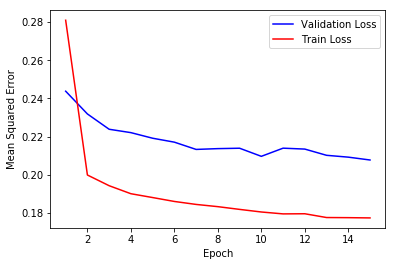

Wall time: 139 ms


In [19]:
%%time
print(max(malstm_trained.history['val_acc']))
print(min(malstm_trained.history['val_loss']))
x = list(range(1, n_epoch+1))
vy = malstm_trained.history['val_loss']
ty = malstm_trained.history['loss']
plot_loss(x, vy, ty)

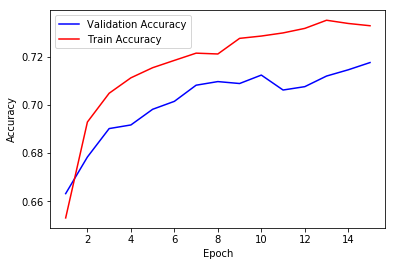

In [20]:
def plot_loss(x, vy, ty, xlabel='Epoch', ylabel='Accuracy'):
    _, = plt.plot(x, vy, 'b', label="Validation Accuracy")
    _, = plt.plot(x, ty, 'r', label="Train Accuracy")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

x = list(range(1, n_epoch+1))
vy = malstm_trained.history['val_acc']
ty = malstm_trained.history['acc']
plot_loss(x, vy, ty)